In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import os
import os.path as path
import seaborn as sns
from tqdm import tqdm
import re

import theano
import pymc3 as pm

sns.reset_orig()

%matplotlib inline
%load_ext autoreload

%autoreload 2
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "24"
sns.set(font_scale=1.5)

In [2]:
DATAPATH = 'Data'

In [3]:
df_1_2 = pd.read_csv(os.path.join(DATAPATH, 'compilation_score.csv'))
df_1_2['all_tasks'] = df_1_2.session > 15
df_1_2['first_all_tasks'] = (15 < df_1_2.session) &  (df_1_2.session < 21)

In [4]:
df_3 = pd.read_csv(os.path.join(DATAPATH, 'df_stats_phase_3.csv'))
df_3['phase'] = 3
df_3 = df_3.rename(columns={'Nb de parties':'session'})
df_3['test'] = df_3.session > 20
df_3['all_tasks'] = df_3.Bloc > 3
df_3['first_all_tasks'] = (15 < df_3.session) &  (df_3.session < 21)
df_3['score_performance'] = df_3.score_flight + df_3.score_pnts##
df_3 = df_3.rename(columns={'# participant':'participant', 'Bloc':'niveau_de_complexite'})
df_3 = df_3[[x for x in df_1_2.columns if x in df_3.columns]]

In [5]:
df_1_2_3 = pd.concat((df_1_2, df_3), sort=True)
df_1_2_3.participant = df_1_2_3.participant + df_1_2_3.phase*100
df_1_2_3 = df_1_2_3[df_1_2_3.participant != 113] # donne éloigné

df_1_2_3.session = df_1_2_3.session.astype(int)

In [6]:
def plot_learning(df, show=True):
    cmap = matplotlib.cm.get_cmap('prism')
    cmap2 = matplotlib.cm.get_cmap('gist_rainbow')
    colors = [(*cmap(x)[:3], 0.4) for x in [0.1, 0.25, 0.5, 0.75, 0.9]]
    colors2 = [(*cmap2(x)[:3], 0.03) for x in np.linspace(0, 1, 10)]

    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.boxplot(x="session", y="score_performance", hue="phase", data=df, palette={1:colors2[5], 2:colors2[7], 3:colors2[1]})
    for idx, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.1))
    ax2 = sns.swarmplot(x='session', y='score_performance', hue="phase", split=True, data=df, color='.0', size=3, palette={1:'0.3', 2:'0.3', 3:'0.3'})
    handles, labels = ax.get_legend_handles_labels()
    for idx, patch in enumerate(handles[:len(handles)//2]):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.1))


    ax.legend(handles[:len(handles)//2], ['FT', 'CPT', 'ACPT'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)
    ax.get_legend().get_frame().set_facecolor('white')

    ax.axis(ymin=-4000)
    ax.set_facecolor('white')
    ax.grid(color='k', linestyle='-', linewidth=0.5, axis='y')
    ax.set_xlabel('Trial Number')
    ax.set_ylabel('Score')

    #fig.savefig('img/final_performance_comparison.png', format='png')
    #fig.savefig('img/final_performance_comparison.svg', format='svg')
    if show:
        plt.show()

# Test phase i.e. session>= 20

## Anova

In [7]:
df_tests = df_1_2_3[df_1_2_3.test]

# compute one-way ANOVA P value	
from scipy import stats

score_1 = df_tests[df_tests.phase==1].score_performance
score_2 = df_tests[df_tests.phase==2].score_performance
score_3 = df_tests[df_tests.phase==3].score_performance


In [8]:
f_val, p_val = stats.f_oneway(score_1, score_2, score_3)

print("One-way ANOVA P =", p_val)

One-way ANOVA P = 0.8122861669005748


## T-test

In [9]:
t, p = stats.ttest_ind(score_1.append(score_2), score_3)
print('t = {}, p = {}'.format(t,p))

t = -0.3605277869761672, p = 0.718672476421887


## Plot

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


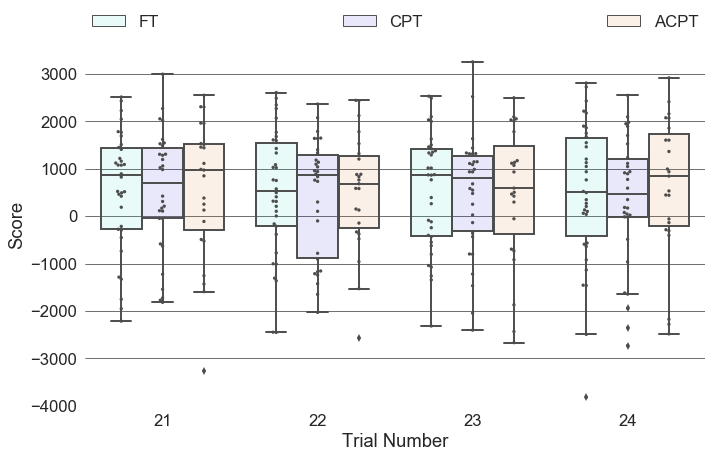

In [10]:
plot_learning(df_tests)

# all with full task i.e. >15

In [11]:
df_all_tasks = df_1_2_3[df_1_2_3.all_tasks]
#has_all9_games = df_all_tasks.groupby('participant').score_performance.count() == 9
#df_all_tasks = df_all_tasks[df_all_tasks.participant.isin(has_all9_games.index[has_all9_games].values)]
#df_all_tasks

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


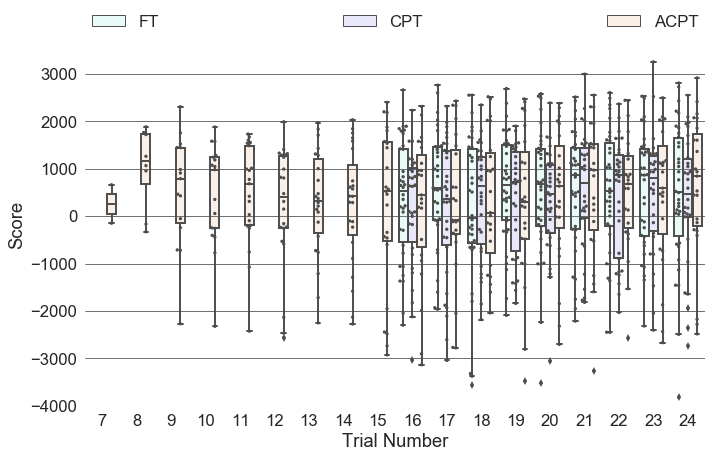

In [12]:
plot_learning(df_all_tasks)

# 5 first time doing all task

In [13]:
df_first_5_all_tasks = df_1_2_3[df_1_2_3.first_all_tasks]

#has_all_5_games = df_first_5_all_tasks.groupby('participant').score_performance.count() == 5
#df_first_5_all_tasks = df_first_5_all_tasks[df_first_5_all_tasks.participant.isin(has_all_5_games.index[has_all_5_games].values)]
#df_first_5_all_tasks

In [14]:
for trial_number in [16, 17, 18, 19, 20]:
    print("##### Trial {} #####".format(trial_number))
    score_1 = df_first_5_all_tasks[(df_first_5_all_tasks.phase==1) & (df_first_5_all_tasks.session==trial_number)].score_performance
    score_2 = df_first_5_all_tasks[(df_first_5_all_tasks.phase==2) & (df_first_5_all_tasks.session==trial_number)].score_performance
    score_3 = df_first_5_all_tasks[(df_first_5_all_tasks.phase==3) & (df_first_5_all_tasks.session==trial_number)].score_performance
    
    t, p = stats.ttest_ind(score_1, score_2)
    print("between 1 and 2")
    print('t = {}, p = {}'.format(t,p))
    
    t, p = stats.ttest_ind(score_1, score_3)
    print("between 1 and 3")
    print('t = {}, p = {}'.format(t,p))

    print("between 2 and 3")
    t, p = stats.ttest_ind(score_2, score_3)
    print('t = {}, p = {}'.format(t,p))

    f_val, p_val = stats.f_oneway(score_1, score_2, score_3)

    print("One-way ANOVA P =", p_val)

##### Trial 16 #####
between 1 and 2
t = 0.626971998425796, p = 0.5329796407771414
between 1 and 3
t = 0.3351658676170694, p = 0.7387749957408305
between 2 and 3
t = -0.19403747760247772, p = 0.8469173527507983
One-way ANOVA P = 0.8349609111232196
##### Trial 17 #####
between 1 and 2
t = 1.34469616226664, p = 0.1836222593343111
between 1 and 3
t = 1.0605420040081046, p = 0.2935332178456269
between 2 and 3
t = -0.1711083223489035, p = 0.8648156762482364
One-way ANOVA P = 0.3802340142117492
##### Trial 18 #####
between 1 and 2
t = -0.5794665940831126, p = 0.564374062992216
between 1 and 3
t = -0.4706586212690653, p = 0.6397458155175886
between 2 and 3
t = 0.0376862666245399, p = 0.9700849582354198
One-way ANOVA P = 0.8120807341679395
##### Trial 19 #####
between 1 and 2
t = 0.8120366139446786, p = 0.4198775095242354
between 1 and 3
t = 0.8853319732984669, p = 0.3798319884711393
between 2 and 3
t = 0.23194332814442933, p = 0.8175102134481891
One-way ANOVA P = 0.6101290959745265
##### Tria

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


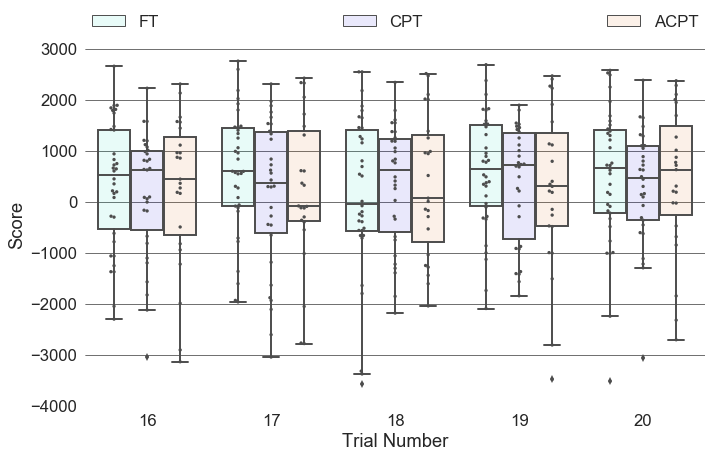

In [15]:
plot_learning(df_first_5_all_tasks)

# 5 together

In [16]:
score_1 = df_first_5_all_tasks[df_first_5_all_tasks.phase==1].score_performance
score_2 = df_first_5_all_tasks[df_first_5_all_tasks.phase==2].score_performance
score_3 = df_first_5_all_tasks[df_first_5_all_tasks.phase==3].score_performance

In [17]:
t, p = stats.ttest_ind(score_1, score_3)
print('t = {}, p = {}'.format(t,p))

t, p = stats.ttest_ind(score_2, score_3)
print('t = {}, p = {}'.format(t,p))

f_val, p_val = stats.f_oneway(score_1, score_2, score_3)

print("One-way ANOVA P =", p_val)

t = 0.8831407210222991, p = 0.3779098230677783
t = -0.1784389037401394, p = 0.8585156713970383
One-way ANOVA P = 0.4490220347616053


C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


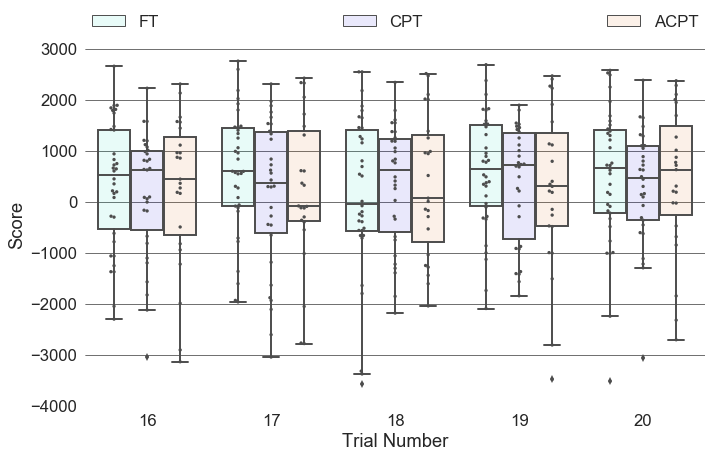

In [18]:
plot_learning(df_first_5_all_tasks, show=False)

# all session

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


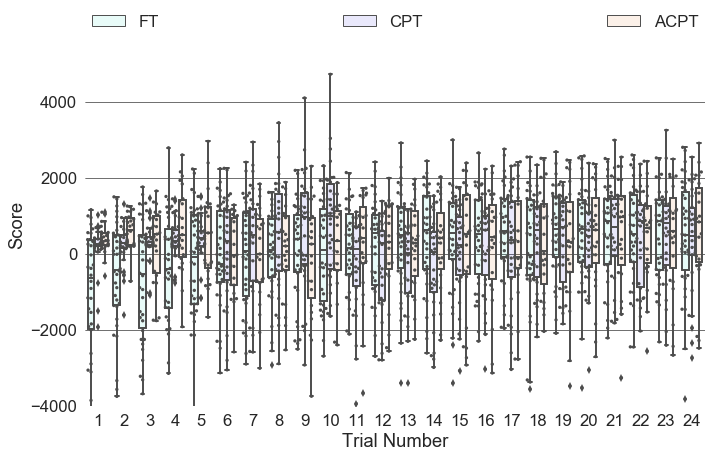

In [19]:
plot_learning(df_1_2_3)

# FT only

## choice of fiting function

[ 4.33157535e+02  4.24259120e-01 -1.01297758e+03]
[ 1.59988414e+02 -4.36807694e-02 -8.37211637e+02]
[ 1.48865966e+03  1.28230578e-01 -8.77567768e+02]


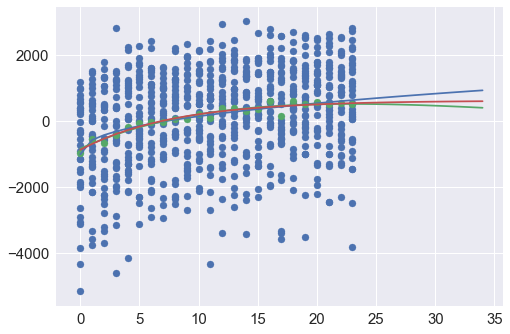

In [20]:
x = df_1_2_3[(df_1_2_3.phase==1) & (df_1_2_3.score_performance>-7500)].session.values - 1
y = df_1_2_3[(df_1_2_3.phase==1) & (df_1_2_3.score_performance>-7500)].score_performance.values

f1 = lambda x, a, b, c : a * x **b + c
p1, cov = scipy.optimize.curve_fit(f1, x, y, method='lm')
print(p1)
plt.plot(np.arange(35), f1(np.arange(35), *p1))

f2 = lambda x, a, b, c : a* x * np.exp(b*x) + c
p2, cov = scipy.optimize.curve_fit(f2, x, y, method='lm')
print(p2)
plt.plot(np.arange(35), f2(np.arange(35), *p2))

f3 = lambda x, a, b, c : a * (1-np.exp(-(b*x))) + c
p3, cov = scipy.optimize.curve_fit(f3, x, y, method='lm')
print(p3)
plt.plot(np.arange(35), f3(np.arange(35), *p3))


plt.scatter(x, y)
plt.scatter(pd.Series(index=x, data=y).groupby(level=0).mean().index, pd.Series(index=x, data=y).groupby(level=0).mean().values)

We choose f3 (first-order response)

In [21]:
def summary(trace):
    pm.plot_posterior(trace)
    plt.show()
    pm.plots.traceplot(trace)
    plt.show()
    pm.plots.energyplot(trace)
    print('Gelman-Rubin ', max(np.max(gr_values) for gr_values in pm.gelman_rubin(trace).values()))
    return pm.summary(trace)

# Maximum a posteriori estimation of fitting function

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


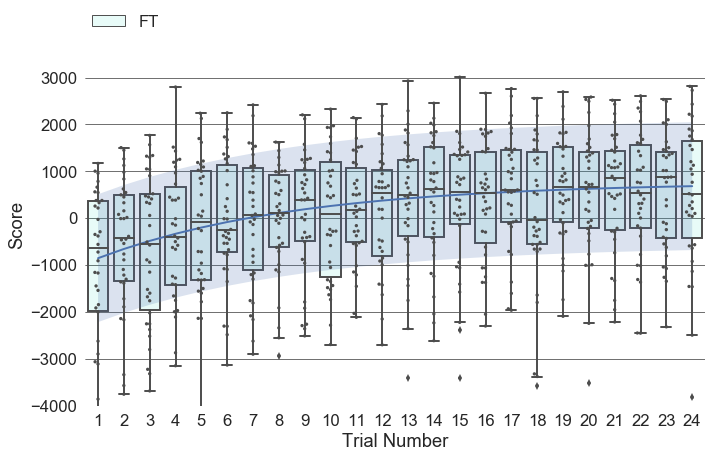

In [25]:
plot_learning(df_1_2_3[df_1_2_3.phase==1], show=False)
plt.plot(np.arange(24), f3(np.arange(24), stat.loc['a', 'mean'], stat.loc['b', 'mean'], stat.loc['c', 'mean']))
plt.fill_between(np.arange(24), f3(np.arange(24), stat.loc['a', 'mean'], stat.loc['b', 'mean'], stat.loc['c', 'mean']) - stat.loc['σ', 'mean'], f3(np.arange(24), stat.loc['a', 'mean'], stat.loc['b', 'mean'], stat.loc['c', 'mean']) + stat.loc['σ', 'mean'], alpha=0.2)

plt.savefig('img/FT-learning-curve.png', format='png', transparent=True)

plt.show()

# CPT results

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


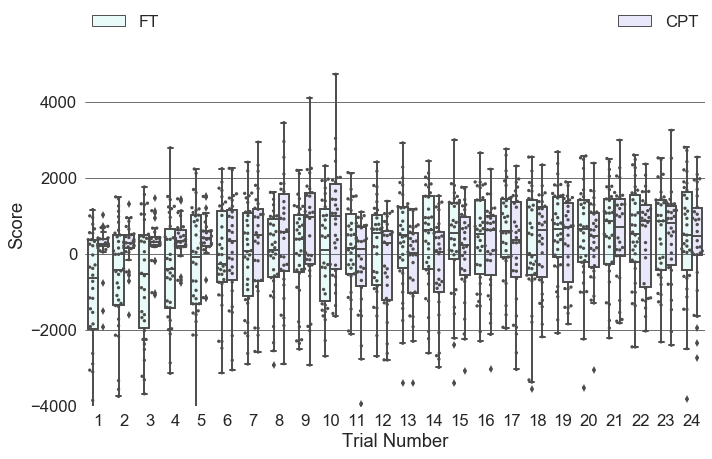

In [26]:
plot_learning(df_1_2_3[df_1_2_3.phase!=3], show=False)
plt.savefig('img/FT-CPT-learning-curve-all.png', format='png', transparent=True)

plt.show()

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


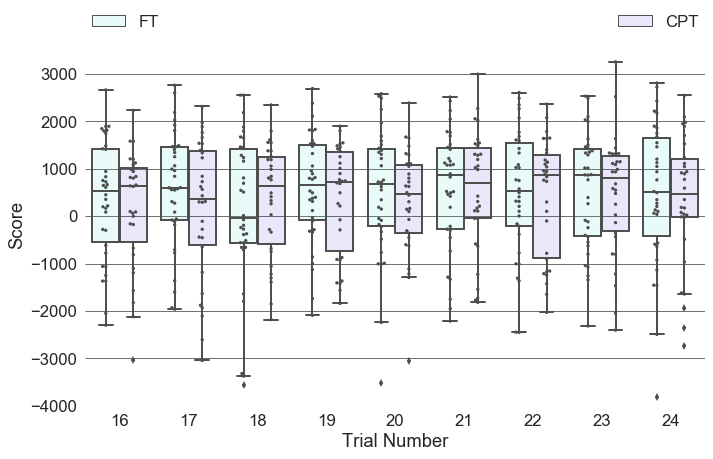

In [27]:
plot_learning(df_all_tasks[df_all_tasks.phase!=3], show=False)
plt.savefig('img/FT-CPT-learning-curve-zoom.png', format='png', transparent=True)

plt.show()

# ACPT results

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


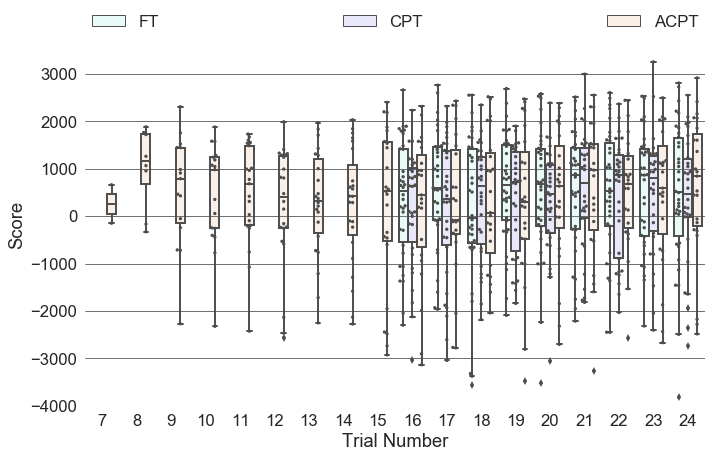

In [28]:
plot_learning(df_all_tasks, show=False)
plt.savefig('img/FT-CPT-ACPT-learning-curve-zoom.png', format='png', transparent=True)

plt.show()

# Bayesian Comparison

In [30]:
x_ft = theano.shared(df_1_2_3[(df_1_2_3.phase==1) & (df_1_2_3.score_performance>-7500)].session.values - 1)
y_ft = theano.shared(df_1_2_3[(df_1_2_3.phase==1) & (df_1_2_3.score_performance>-7500)].score_performance.values / df_1_2_3.score_performance.max() )

x_cpt = theano.shared(df_1_2_3[(df_1_2_3.phase==2) & (df_1_2_3['all_tasks'])].session.values - 1)
y_cpt = theano.shared(df_1_2_3[(df_1_2_3.phase==2) & (df_1_2_3['all_tasks'])].score_performance.values/ df_1_2_3.score_performance.max())

x_acpt = theano.shared(df_1_2_3[(df_1_2_3.phase==3) & (df_1_2_3['all_tasks'])].session.values - 1)
y_acpt = theano.shared(df_1_2_3[(df_1_2_3.phase==3) & (df_1_2_3['all_tasks'])].score_performance.values/ df_1_2_3.score_performance.max())

### effect of tau (learning rate)

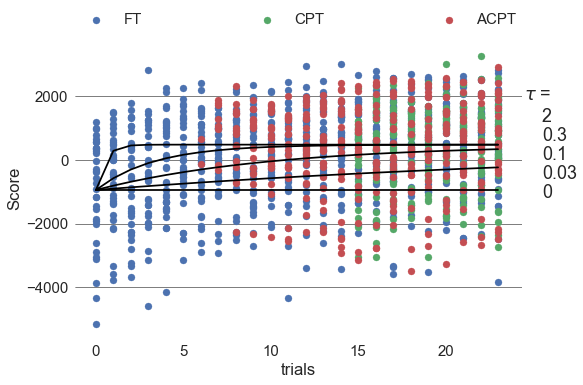

In [51]:
for xv, yv in zip([x_ft, x_cpt, x_acpt], [y_ft, y_cpt, y_acpt]):
    plt.scatter(xv.get_value(), yv.get_value()*df_1_2_3.score_performance.max())
    
    plt.legend(['FT', 'CPT', 'ACPT'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

for idx, b in enumerate([0, 0.03, 0.1, 0.3, 2]):
    plt.plot(np.arange(24), f3(np.arange(24), 0.3, b, -0.2)*df_1_2_3.score_performance.max(), color='k', label=b)
    plt.text(25.5, (idx/8 -0.25)*df_1_2_3.score_performance.max(), str(b))

plt.xlabel('trials')
plt.ylabel('Score')
plt.text(24.5, .4*df_1_2_3.score_performance.max(), r'$\tau$ = ')
plt.gca().set_facecolor('white')
plt.gca().grid(color='k', linestyle='-', linewidth=0.5, axis='y')

plt.savefig('img/tau_comparison.png', format='png', transparent=True)
plt.show()

## PYMC3 model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_log__, c, τ_acpt, τ_cpt, τ_ft_interval__, a_interval__]


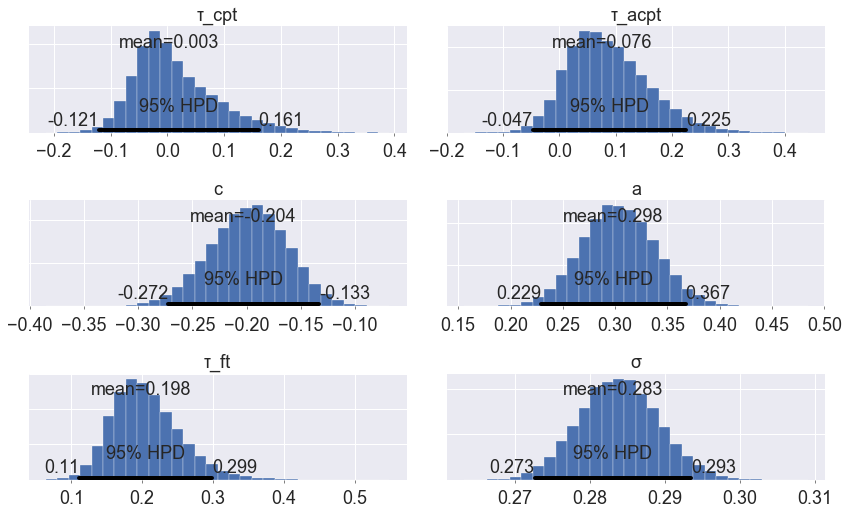

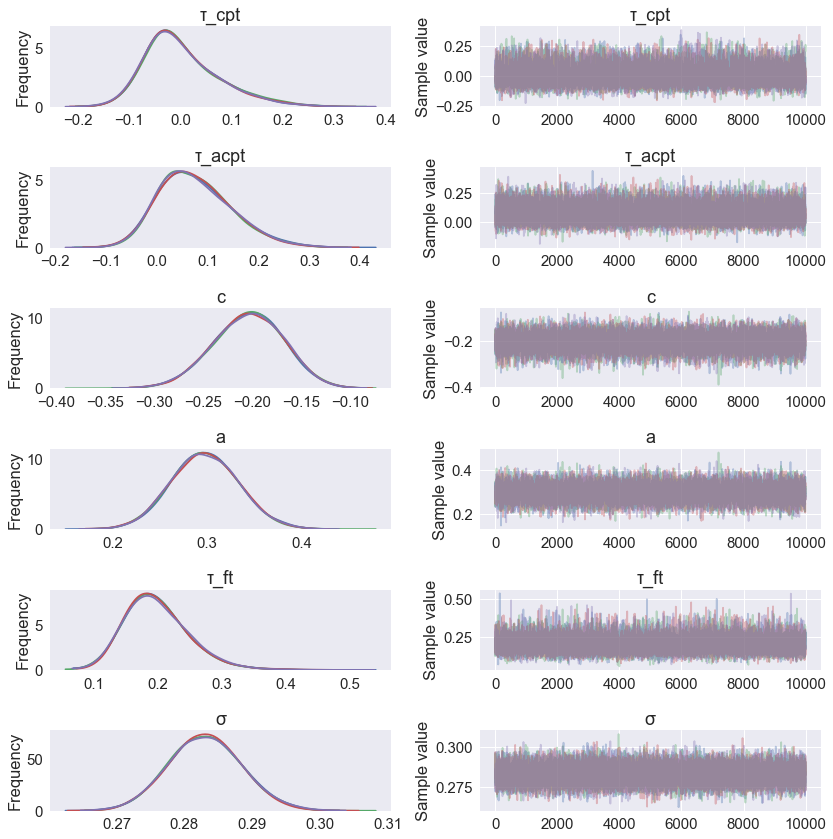

Gelman-Rubin  1.0000377083253533


mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
τ_cpt   0.003089  0.073158  0.000634 -0.120833  0.161019  16817.804577   
τ_acpt  0.076452  0.070857  0.000484 -0.046755  0.224898  22667.444433   
c      -0.203584  0.035792  0.000286 -0.272160 -0.132826  13730.878028   
a       0.297996  0.035156  0.000259  0.229347  0.367273  15095.058842   
τ_ft    0.198177  0.049519  0.000361  0.110396  0.298741  19971.401551   
σ       0.283126  0.005318  0.000025  0.272628  0.293446  36870.894293   

            Rhat  
τ_cpt   1.000038  
τ_acpt  0.999976  
c       0.999982  
a       1.000004  
τ_ft    0.999971  
σ       0.999971

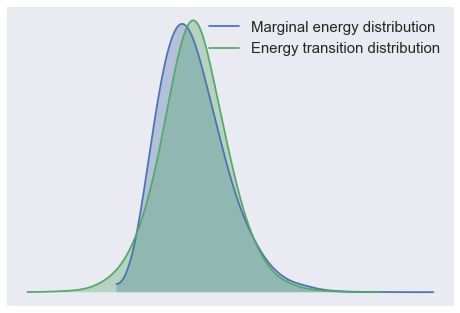

In [47]:
with pm.Model() as model:
    a = pm.Uniform('a', 0, 1)
    
    b_ft = pm.Uniform('τ_ft', 0, 4)
    
    b_cpt = b_ft + pm.Normal('τ_cpt', mu=0, sd=0.1)
    b_acpt = b_ft + pm.Normal('τ_acpt', mu=0, sd=0.1)
    
    
    c = pm.Normal('c', mu=0, sd=0.5, testval=-0.5)
    
    σ = pm.HalfCauchy('σ', 1, testval=0.5)
    
    μ_ft = a * (1-np.exp(-(b_ft * x_ft))) + c 
    obs_ft = pm.Normal('y_ft', mu=μ_ft, sd=σ, observed=y_ft)
    
    μ_cpt = a * (1-np.exp(-(b_cpt * x_cpt))) + c 
    obs_cpt = pm.Normal('y_cpt', mu=μ_cpt, sd=σ, observed=y_cpt)
    
    μ_acpt = a * (1-np.exp(-(b_acpt * x_acpt))) + c 
    obs_acpt = pm.Normal('y_acpt', mu=μ_acpt, sd=σ, observed=y_acpt)
    
#    δb_cpt = pm.Deterministic('δb_cpt', b_cpt-b_ft)
#    δb_acpt = pm.Deterministic('δb_acpt', b_acpt-b_ft)
    
    trace = pm.sample(draws=1e4, tune=2000, target_accept=0.85)
    
stat = summary(trace)
stat

In [48]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x19015048>,
 <matplotlib.gridspec.GridSpec at 0x17c8ee10>)

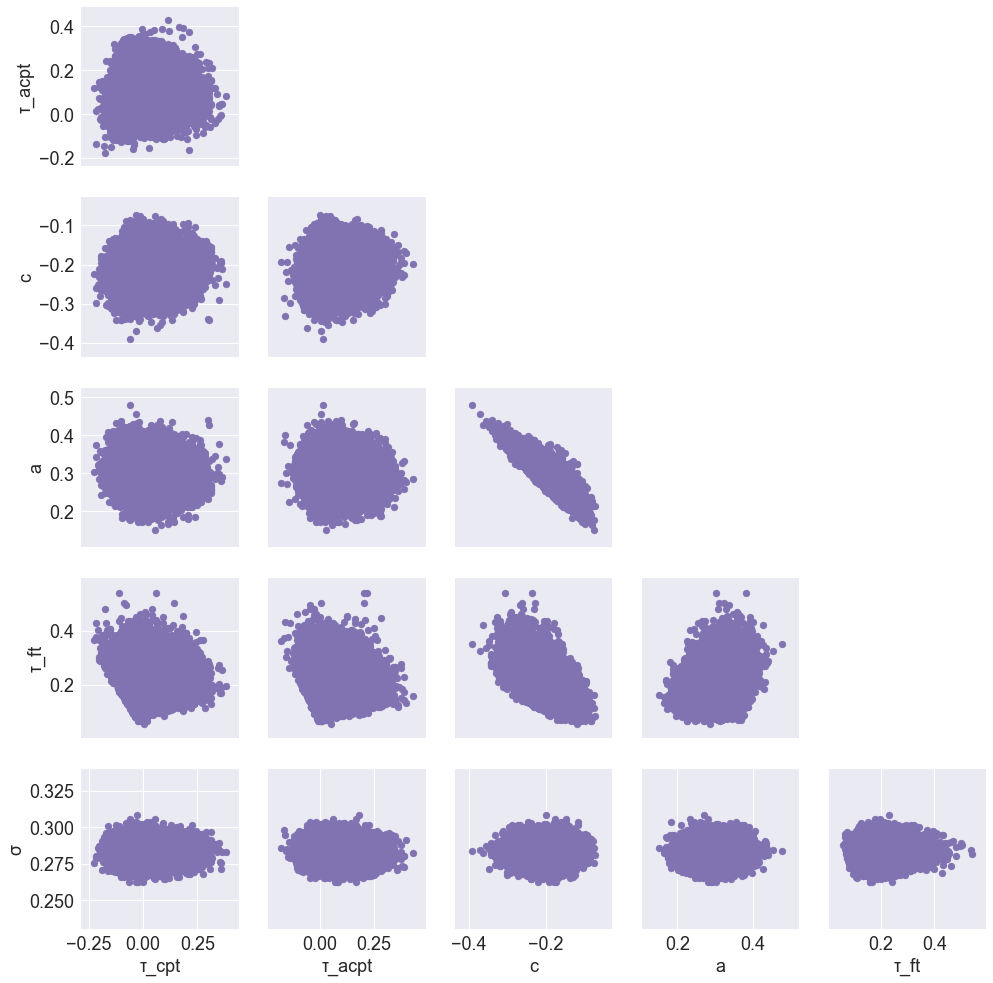

In [53]:
pm.pairplot(trace,
           #sub_varnames=['a', 'b', 'c'],
           divergences=True,
           color='C3', kwargs_divergence={'color':'C2'})

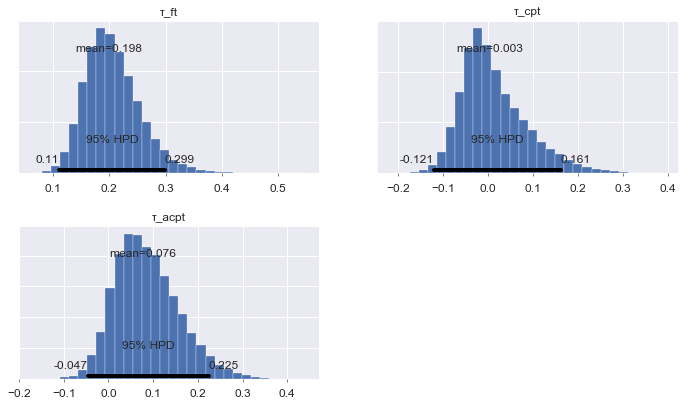

In [68]:
pm.plot_posterior(trace, figsize=(10,6), varnames=['τ_ft', 'τ_cpt', 'τ_acpt'])
plt.savefig('img/posterior.png', format='png', transparent=True)
plt.show()

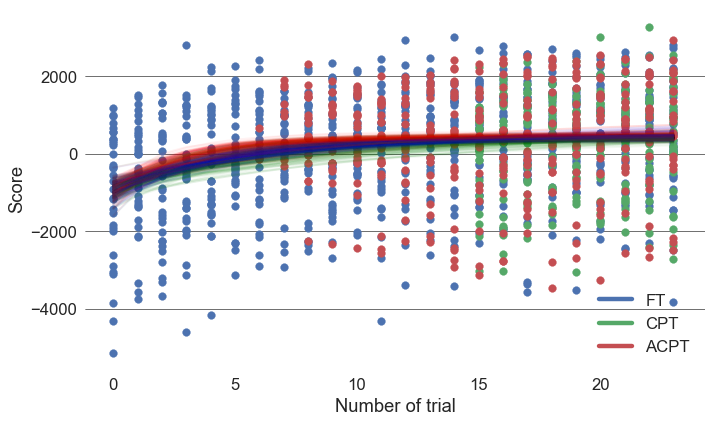

In [69]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

for xv, yv in zip([x_ft, x_cpt, x_acpt], [y_ft, y_cpt, y_acpt]):
    plt.scatter(xv.get_value(), yv.get_value()*df_1_2_3.score_performance.max())

n = 200
for i in range(n):
    plt.plot(np.arange(24), f3(np.arange(24), trace['a'][i], trace['τ_ft'][i], trace['c'][i] )*df_1_2_3.score_performance.max(), c='b', alpha=0.05)
    plt.plot(np.arange(24), f3(np.arange(24), trace['a'][i], trace['τ_ft'][i] + trace['τ_cpt'][i], trace['c'][i] )*df_1_2_3.score_performance.max(), c='g', alpha=0.05)     
    plt.plot(np.arange(24), f3(np.arange(24), trace['a'][i], trace['τ_ft'][i] + trace['τ_acpt'][i], trace['c'][i] )*df_1_2_3.score_performance.max(), c='r', alpha=0.05)   
    

plt.xlabel('Number of trial')
plt.ylabel('Score')

plt.gca().set_facecolor('white')
plt.gca().grid(color='k', linestyle='-', linewidth=0.5, axis='y')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=sns.color_palette()[0], lw=4),
                Line2D([0], [0], color=sns.color_palette()[1], lw=4),
                Line2D([0], [0], color=sns.color_palette()[2], lw=4)]

plt.gca().legend(custom_lines, ['FT', 'CPT', 'ACPT'])
    
plt.savefig('img/learning-curves.png', format='png', transparent=True)
plt.show()

In [56]:
print("Chances that CPT is no better than FT : {0:.1%}".format(np.sum(trace['τ_cpt'] < 0) / len(trace['τ_cpt'])))

Chances that CPT is no better than FT : 56.4%


In [57]:
print("Chances that ACPT is no better than FT : {0:.1%}".format(np.sum(trace['τ_acpt'] < 0) / len(trace['τ_acpt'])))

Chances that ACPT is no better than FT : 12.6%
